# Preparing Data

In [10]:
import os
os.chdir('/kaggle/input/sign-language-mnist/')

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

In [13]:
train_data.shape, test_data.shape

((27455, 785), (7172, 785))

In [14]:
def dataframe_to_arrays(dataframe):
    
    inputs_array = dataframe.iloc[:, 1:].to_numpy()
    targets_array = dataframe['label'].to_numpy()
    
    return inputs_array, targets_array

In [15]:
inputs_array, targets_array = dataframe_to_arrays(train_data)
inputs_array, targets_array

(array([[107, 118, 127, ..., 204, 203, 202],
        [155, 157, 156, ..., 103, 135, 149],
        [187, 188, 188, ..., 195, 194, 195],
        ...,
        [174, 174, 174, ..., 202, 200, 200],
        [177, 181, 184, ...,  64,  87,  93],
        [179, 180, 180, ..., 205, 209, 215]]),
 array([ 3,  6,  2, ..., 18, 17, 23]))

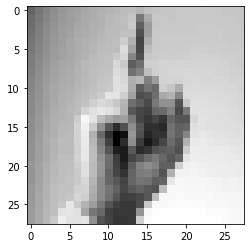

Alphabet :  D


In [16]:
image = np.reshape(inputs_array[0], (28, 28))
plt.imshow(image, cmap = "gray")
plt.show()

print("Alphabet : ", chr(65+targets_array[0]))

In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [18]:
inputs = torch.tensor(inputs_array , dtype=torch.float32)
targets = torch.tensor(targets_array , dtype=torch.long)

In [19]:
dataset = TensorDataset(inputs, targets)

In [20]:
val_percent = 0.15 
num_rows = train_data.shape[0]

val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [21]:
inputs_array_test, targets_array_test = dataframe_to_arrays(test_data)

inputs_test = torch.tensor(inputs_array_test , dtype=torch.float32)
targets_test = torch.tensor(targets_array_test , dtype=torch.long)

test_ds = TensorDataset(inputs_test, targets_test)

# Models

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader] 
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    history=[]
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        for batch in train_loader:
            
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [26]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [27]:
batch_size = 128

## Logistic Regression

In [28]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size) 

In [29]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[105., 111., 118.,  ..., 184., 183., 182.],
        [139., 147., 151.,  ..., 226., 193., 204.],
        [164., 165., 167.,  ...,  68.,  72.,  53.],
        ...,
        [155., 156., 158.,  ..., 168., 168., 166.],
        [183., 187., 191.,  ..., 253., 251., 249.],
        [132., 135., 138.,  ..., 187., 186., 186.]])
targets: tensor([ 3, 20, 20, 19, 11,  7, 11, 19, 23, 16, 19,  8, 19, 11,  5, 22,  6, 21,
         7, 12, 21, 24, 14, 24,  1,  5,  0, 21,  0, 10,  8, 18,  3, 18,  7, 20,
        23,  4,  6, 13, 24, 12, 19, 15, 10, 12, 11, 15, 23, 10, 21, 21,  6, 13,
        20,  1,  0,  5, 19,  1, 10, 17, 22, 21,  5, 13, 12, 12, 12, 23, 22, 22,
        19, 18, 13,  2, 16, 19, 21, 20,  7,  3, 16, 23, 14, 23, 17, 16,  4,  1,
        14, 12, 13,  2, 15, 10,  0,  4, 23, 13,  2,  5, 16, 15,  6, 18, 20, 16,
        17, 17, 10, 18, 22,  5, 15,  4, 10,  1, 16, 14, 14, 17, 18, 22, 19, 21,
         5,  5])


In [30]:
input_size = 28*28
num_classes = 26

In [31]:
class aslLogisticRegression(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
   

In [32]:
model = aslLogisticRegression()

In [33]:
evaluate(model, val_loader)

{'val_loss': 198.90640258789062, 'val_acc': 0.034521348774433136}

In [34]:
learning_rate = 0.0001

In [35]:
history = fit(70, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 312.7919, val_acc: 0.1755
Epoch [1], val_loss: 200.7719, val_acc: 0.2220
Epoch [2], val_loss: 107.4409, val_acc: 0.3041
Epoch [3], val_loss: 65.9176, val_acc: 0.4614
Epoch [4], val_loss: 48.1601, val_acc: 0.5873
Epoch [5], val_loss: 63.4737, val_acc: 0.5082
Epoch [6], val_loss: 54.1278, val_acc: 0.5134
Epoch [7], val_loss: 55.7363, val_acc: 0.4818
Epoch [8], val_loss: 27.4439, val_acc: 0.6830
Epoch [9], val_loss: 66.6480, val_acc: 0.5695
Epoch [10], val_loss: 25.0573, val_acc: 0.6604
Epoch [11], val_loss: 32.3802, val_acc: 0.5988
Epoch [12], val_loss: 33.6453, val_acc: 0.5705
Epoch [13], val_loss: 20.9723, val_acc: 0.7412
Epoch [14], val_loss: 42.6095, val_acc: 0.5883
Epoch [15], val_loss: 16.3942, val_acc: 0.6952
Epoch [16], val_loss: 15.0184, val_acc: 0.7034
Epoch [17], val_loss: 12.2462, val_acc: 0.7292
Epoch [18], val_loss: 26.2178, val_acc: 0.5857
Epoch [19], val_loss: 26.6945, val_acc: 0.6697
Epoch [20], val_loss: 70.6662, val_acc: 0.4615
Epoch [21], val_loss

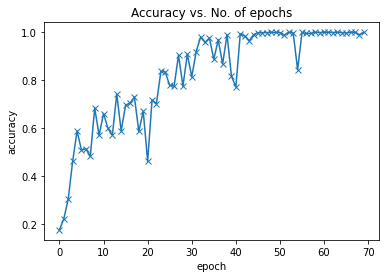

In [36]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [37]:
result = evaluate(model, test_loader)
result

{'val_loss': 15.275585174560547, 'val_acc': 0.6879112124443054}

## Feedforward Neural Network

In [38]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size) 

In [39]:
input_size = 28*28
hidden_layer1 = 28*14
hidden_layer2 = 100
hidden_layer3 = 50
num_classes = 26

In [40]:
class ffNeuralNetwork(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_layer1)
        self.linear2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.linear3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.linear4 = nn.Linear(hidden_layer3, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out
    

In [41]:
model = ffNeuralNetwork()

In [42]:
evaluate(model, val_loader)

{'val_loss': 12.57900619506836, 'val_acc': 0.042333848774433136}

In [43]:
learning_rate = 0.0001

In [44]:
history = fit(70, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 3.0647, val_acc: 0.1244
Epoch [1], val_loss: 2.8128, val_acc: 0.1527
Epoch [2], val_loss: 2.5264, val_acc: 0.2353
Epoch [3], val_loss: 2.2825, val_acc: 0.3031
Epoch [4], val_loss: 2.0756, val_acc: 0.3775
Epoch [5], val_loss: 1.9447, val_acc: 0.4122
Epoch [6], val_loss: 1.8479, val_acc: 0.4550
Epoch [7], val_loss: 1.7299, val_acc: 0.4832
Epoch [8], val_loss: 1.6909, val_acc: 0.4848
Epoch [9], val_loss: 1.5074, val_acc: 0.5520
Epoch [10], val_loss: 1.4578, val_acc: 0.5679
Epoch [11], val_loss: 1.3609, val_acc: 0.5999
Epoch [12], val_loss: 1.3066, val_acc: 0.6251
Epoch [13], val_loss: 1.3139, val_acc: 0.5923
Epoch [14], val_loss: 1.1702, val_acc: 0.6633
Epoch [15], val_loss: 1.1576, val_acc: 0.6606
Epoch [16], val_loss: 1.1377, val_acc: 0.6631
Epoch [17], val_loss: 1.0649, val_acc: 0.6934
Epoch [18], val_loss: 1.0735, val_acc: 0.6783
Epoch [19], val_loss: 0.9762, val_acc: 0.7345
Epoch [20], val_loss: 0.9631, val_acc: 0.7302
Epoch [21], val_loss: 0.9480, val_acc: 0.734

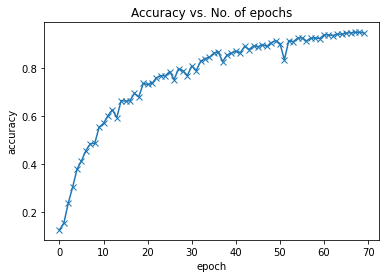

In [45]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [46]:
result = evaluate(model, test_loader)
result

{'val_loss': 1.1213221549987793, 'val_acc': 0.6732456088066101}

# To load Data and Model to GPU 

In [47]:
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

## Convolution Neural Network

In [48]:
device = get_default_device()

In [49]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size) 

In [50]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [51]:
num_classes = 26

In [52]:
class CNNModel(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        
        self.network = nn.Sequential(
        
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 


            nn.Flatten(), 
            nn.Linear(128*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        
        )
        
        
    def forward(self, xb):
        
        xb = xb.reshape(-1,1,28,28)
        return self.network(xb)

In [53]:
model = to_device(CNNModel(), device)

In [54]:
evaluate(model, val_dl)

{'val_loss': 3.404240131378174, 'val_acc': 0.0004734848625957966}

In [55]:
learning_rate = 0.0001

In [56]:
history = fit(70, learning_rate, model, train_dl, val_dl)

Epoch [0], val_loss: 3.1219, val_acc: 0.1210
Epoch [1], val_loss: 3.0588, val_acc: 0.1719
Epoch [2], val_loss: 2.9886, val_acc: 0.2379
Epoch [3], val_loss: 2.8896, val_acc: 0.3014
Epoch [4], val_loss: 2.7660, val_acc: 0.2751
Epoch [5], val_loss: 2.6000, val_acc: 0.3412
Epoch [6], val_loss: 2.4598, val_acc: 0.2645
Epoch [7], val_loss: 2.2707, val_acc: 0.3712
Epoch [8], val_loss: 2.1336, val_acc: 0.3622
Epoch [9], val_loss: 2.0748, val_acc: 0.3455
Epoch [10], val_loss: 2.0571, val_acc: 0.3622
Epoch [11], val_loss: 1.8451, val_acc: 0.4355
Epoch [12], val_loss: 1.9051, val_acc: 0.4453
Epoch [13], val_loss: 2.0660, val_acc: 0.3492
Epoch [14], val_loss: 1.8159, val_acc: 0.4202
Epoch [15], val_loss: 1.5133, val_acc: 0.5370
Epoch [16], val_loss: 1.3863, val_acc: 0.5476
Epoch [17], val_loss: 1.3858, val_acc: 0.5605
Epoch [18], val_loss: 1.1978, val_acc: 0.5994
Epoch [19], val_loss: 1.3453, val_acc: 0.5304
Epoch [20], val_loss: 1.3784, val_acc: 0.5573
Epoch [21], val_loss: 1.1656, val_acc: 0.625

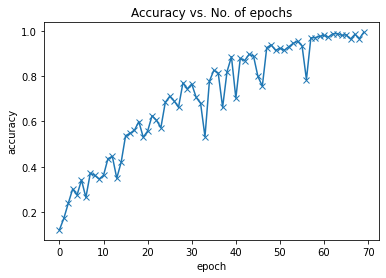

In [57]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [58]:
test_dl = DeviceDataLoader(test_loader, device)

In [59]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.5657356977462769, 'val_acc': 0.8234649300575256}

## Save on jovian

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian
project_name = 'image-classification-on-american-sign-language-dataset'

In [63]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/image-classification-on-american-sign-language-dataset


<IPython.core.display.Javascript object>